# Trainable MNIST

Raytune has a great collection of [examples](https://github.com/ray-project/ray/tree/master/python/ray/tune/examples) and I have picked a simple one to impement in a notebook. This is godo to play with if you are within a GPU or want to try a *big* parameter search as it's relatively quick and easy to train.


## What is MNIST?

In case you are unfamilar MNIST is a standard handwritten character dataset used widely in Machine Learning examples. The dataset consists of 70,000 28x28 images (60,000 training and 10,000 test)


Here are some examples from the dataset [source: wikipedia](https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)

![MNIST Examples](MnistExamples.png)



### Load Dependencies

We load the usual deps and also load [PyTorch](https://pytorch.org/docs/stable/index.html) so that we can define a small Neural Network to train as a classifer

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Dataloaders

We'll re-use some standard dataloaders from the ray examples. This function returns 2 pytorch dataloaders, one for train and one for test

In [3]:
from mnist_pytorch import get_data_loaders

## Network

We define a very small ConvNET with a single Conv2D layer and single Linear Layer

Things to Try:
 - Try building up larger networks to see if performance improves
 - Try adding options to the `__init__()` function to vary layer properties or the number of layers and tune these new parameters

In [4]:
class ConvNet(nn.Module):
    def __init__(self, width=3):
        super(ConvNet, self).__init__()       
        self.width=width
        
        self.conv1 = nn.Conv2d(1, width, kernel_size=3)
        self.fc = nn.Linear(width*8*8, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.width*8*8)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## Train & Test Functions

We define some functions for out training and testing loops

During training, we iterate over examples while calculating losses, backpropagating and optimising the network

In [5]:
EPOCH_SIZE = 512

def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

During test time we iterate over the test set and calculate performance metrics

In [6]:
TEST_SIZE=256

def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

## Check for CUDA

In [7]:
print('CUDA Available :D') if torch.cuda.is_available() else print('CPU Only :O')

CUDA Available :D


## Start Ray

In [11]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=1, include_webui=True)

2020-06-12 11:24:03,665	INFO resource_spec.py:204 -- Starting Ray with 32.71 GiB memory available for workers and up to 16.37 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-12 11:24:03,932	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:57296',
 'object_store_address': '/tmp/ray/session_2020-06-12_11-24-03_664057_136391/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-12_11-24-03_664057_136391/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-12_11-24-03_664057_136391'}

In [9]:
from os import path

class TrainMNIST(tune.Trainable):
    
    def _setup(self, config):
        # detect if cuda is availalbe as ray will assign GPUs if available and configured
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #
        # In this case this will also fetch the MNIST data on first run
        #
        self.train_loader, self.test_loader = get_data_loaders()
        
        # create the network
        self.model = ConvNet(
            # pass in parameters here if we want to tune network internals
        ).to(self.device)
        
        #setup the optimiser (try Adam instead and change parameters we are tuning)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))
                

    def _train(self):
        
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        
        acc = test(self.model, self.test_loader, self.device)
        
        return {"mean_accuracy": acc}
    
    
    def _save(self, checkpoint_dir):
        checkpoint_path = path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path
    
    
    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))

In [16]:
config = {
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
    }


analysis = tune.run(
    TrainMNIST,
    config=config,
    local_dir="~/ray_results/torch_mnist",
    resources_per_trial={
        "cpu": 2,
        "gpu": 0
    },
    num_samples=3,
    checkpoint_at_end=True,
    checkpoint_freq=10,
#     keep_checkpoints_num=3, # only keep n best checkpoints
    stop={
        "mean_accuracy": 0.99,
        "training_iteration": 100,
    })



Trial name,status,loc,lr,momentum
TrainMNIST_00000,RUNNING,,0.0405368,0.587597
TrainMNIST_00001,PENDING,,0.0283701,0.406529
TrainMNIST_00002,PENDING,,0.0590641,0.10825


(pid=136618) 2020-06-12 11:27:56,240	INFO trainable.py:217 -- Getting current IP.
(pid=136617) 2020-06-12 11:27:56,300	INFO trainable.py:217 -- Getting current IP.
(pid=136611) 2020-06-12 11:27:56,355	INFO trainable.py:217 -- Getting current IP.
Result for TrainMNIST_00000:
  date: 2020-06-12_11-27-56
  done: false
  experiment_id: 981d1868b5ac45e1bf9be90453977ddd
  experiment_tag: 0_lr=0.040537,momentum=0.5876
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_accuracy: 0.221875
  node_ip: 192.168.1.39
  pid: 136618
  time_since_restore: 0.2382349967956543
  time_this_iter_s: 0.2382349967956543
  time_total_s: 0.2382349967956543
  timestamp: 1591957676
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '00000'
  
Result for TrainMNIST_00001:
  date: 2020-06-12_11-27-56
  done: false
  experiment_id: da5ec95ff12240b3838bc2f1afe05a7e
  experiment_tag: 1_lr=0.02837,momentum=0.40653
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_accuracy: 0.609375
  node_

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:136618,0.0405368,0.587597,0.89375,16,3.87851
TrainMNIST_00001,RUNNING,192.168.1.39:136617,0.0283701,0.406529,0.884375,17,4.06
TrainMNIST_00002,RUNNING,192.168.1.39:136611,0.0590641,0.10825,0.8625,16,3.80447


Result for TrainMNIST_00000:
  date: 2020-06-12_11-28-01
  done: false
  experiment_id: 981d1868b5ac45e1bf9be90453977ddd
  experiment_tag: 0_lr=0.040537,momentum=0.5876
  hostname: cosmos-ml
  iterations_since_restore: 22
  mean_accuracy: 0.89375
  node_ip: 192.168.1.39
  pid: 136618
  time_since_restore: 5.351626396179199
  time_this_iter_s: 0.2372739315032959
  time_total_s: 5.351626396179199
  timestamp: 1591957681
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: '00000'
  
Result for TrainMNIST_00001:
  date: 2020-06-12_11-28-01
  done: false
  experiment_id: da5ec95ff12240b3838bc2f1afe05a7e
  experiment_tag: 1_lr=0.02837,momentum=0.40653
  hostname: cosmos-ml
  iterations_since_restore: 22
  mean_accuracy: 0.884375
  node_ip: 192.168.1.39
  pid: 136617
  time_since_restore: 5.293994665145874
  time_this_iter_s: 0.2415311336517334
  time_total_s: 5.293994665145874
  timestamp: 1591957681
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: '00001'
  
R

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:136618,0.0405368,0.587597,0.921875,38,9.1147
TrainMNIST_00001,RUNNING,192.168.1.39:136617,0.0283701,0.406529,0.903125,37,8.8376
TrainMNIST_00002,RUNNING,192.168.1.39:136611,0.0590641,0.10825,0.896875,37,8.77706


Result for TrainMNIST_00001:
  date: 2020-06-12_11-28-06
  done: false
  experiment_id: da5ec95ff12240b3838bc2f1afe05a7e
  experiment_tag: 1_lr=0.02837,momentum=0.40653
  hostname: cosmos-ml
  iterations_since_restore: 43
  mean_accuracy: 0.896875
  node_ip: 192.168.1.39
  pid: 136617
  time_since_restore: 10.24218225479126
  time_this_iter_s: 0.23179054260253906
  time_total_s: 10.24218225479126
  timestamp: 1591957686
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: '00001'
  
Result for TrainMNIST_00000:
  date: 2020-06-12_11-28-06
  done: false
  experiment_id: 981d1868b5ac45e1bf9be90453977ddd
  experiment_tag: 0_lr=0.040537,momentum=0.5876
  hostname: cosmos-ml
  iterations_since_restore: 44
  mean_accuracy: 0.928125
  node_ip: 192.168.1.39
  pid: 136618
  time_since_restore: 10.518092155456543
  time_this_iter_s: 0.24366211891174316
  time_total_s: 10.518092155456543
  timestamp: 1591957686
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: '00000'

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:136618,0.0405368,0.587597,0.934375,58,13.8723
TrainMNIST_00001,RUNNING,192.168.1.39:136617,0.0283701,0.406529,0.928125,59,13.9779
TrainMNIST_00002,RUNNING,192.168.1.39:136611,0.0590641,0.10825,0.95,59,13.8805


Result for TrainMNIST_00001:
  date: 2020-06-12_11-28-11
  done: false
  experiment_id: da5ec95ff12240b3838bc2f1afe05a7e
  experiment_tag: 1_lr=0.02837,momentum=0.40653
  hostname: cosmos-ml
  iterations_since_restore: 65
  mean_accuracy: 0.903125
  node_ip: 192.168.1.39
  pid: 136617
  time_since_restore: 15.384952306747437
  time_this_iter_s: 0.2303328514099121
  time_total_s: 15.384952306747437
  timestamp: 1591957691
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: '00001'
  
Result for TrainMNIST_00000:
  date: 2020-06-12_11-28-12
  done: false
  experiment_id: 981d1868b5ac45e1bf9be90453977ddd
  experiment_tag: 0_lr=0.040537,momentum=0.5876
  hostname: cosmos-ml
  iterations_since_restore: 65
  mean_accuracy: 0.940625
  node_ip: 192.168.1.39
  pid: 136618
  time_since_restore: 15.526732206344604
  time_this_iter_s: 0.23478364944458008
  time_total_s: 15.526732206344604
  timestamp: 1591957692
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: '00000

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:136618,0.0405368,0.587597,0.896875,80,19.021
TrainMNIST_00001,RUNNING,192.168.1.39:136617,0.0283701,0.406529,0.915625,79,18.8258
TrainMNIST_00002,RUNNING,192.168.1.39:136611,0.0590641,0.10825,0.946875,80,18.8054


Result for TrainMNIST_00001:
  date: 2020-06-12_11-28-16
  done: false
  experiment_id: da5ec95ff12240b3838bc2f1afe05a7e
  experiment_tag: 1_lr=0.02837,momentum=0.40653
  hostname: cosmos-ml
  iterations_since_restore: 85
  mean_accuracy: 0.921875
  node_ip: 192.168.1.39
  pid: 136617
  time_since_restore: 20.331984043121338
  time_this_iter_s: 0.25345897674560547
  time_total_s: 20.331984043121338
  timestamp: 1591957696
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: '00001'
  
Result for TrainMNIST_00002:
  date: 2020-06-12_11-28-17
  done: false
  experiment_id: 1bdeb310c96c4e5bb1883ba93e2faf7e
  experiment_tag: 2_lr=0.059064,momentum=0.10825
  hostname: cosmos-ml
  iterations_since_restore: 87
  mean_accuracy: 0.94375
  node_ip: 192.168.1.39
  pid: 136611
  time_since_restore: 20.478273153305054
  time_this_iter_s: 0.2333536148071289
  time_total_s: 20.478273153305054
  timestamp: 1591957697
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: '00002

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0405368,0.587597,0.95,100,23.7305
TrainMNIST_00001,RUNNING,192.168.1.39:136617,0.0283701,0.406529,0.909375,100,24.0853
TrainMNIST_00002,TERMINATED,,0.0590641,0.10825,0.95,100,23.5646


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0405368,0.587597,0.95,100,23.7305
TrainMNIST_00001,TERMINATED,,0.0283701,0.406529,0.909375,100,24.0853
TrainMNIST_00002,TERMINATED,,0.0590641,0.10825,0.95,100,23.5646


In [17]:
from pprint import pprint
print("Best config is:")
pprint(analysis.get_best_trial(metric="mean_accuracy"))
pprint(analysis.get_best_config(metric="mean_accuracy"))

Best config is:
TrainMNIST_00001
{'lr': 0.028370071544628866, 'momentum': 0.4065294092602024}


## Load a model and check results

In [18]:
train_loader, test_loader = get_data_loaders()

In [19]:
X, y = list(test_loader)[np.random.randint(0, len(test_loader))]

#### Find the model checkpoint you want to load

In [20]:
checkpoint_path = path.join(path.expanduser('~'),'ray_results','torch_mnist','TrainMNIST',
                          'TrainMNIST_1_lr=0.02837,momentum=0.40653_2020-06-12_11-27-558a5m3jyk',
                         'checkpoint_100', 'model.pth')
print(path.exists(checkpoint_path))

True


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.set_grad_enabled(False):
    model = ConvNet()
    model.load_state_dict(torch.load(checkpoint_path))
    
    model.to(device)
    
    y_ = model(X.to(device)).cpu()
    
    _, predicted = torch.max(y_, 1)

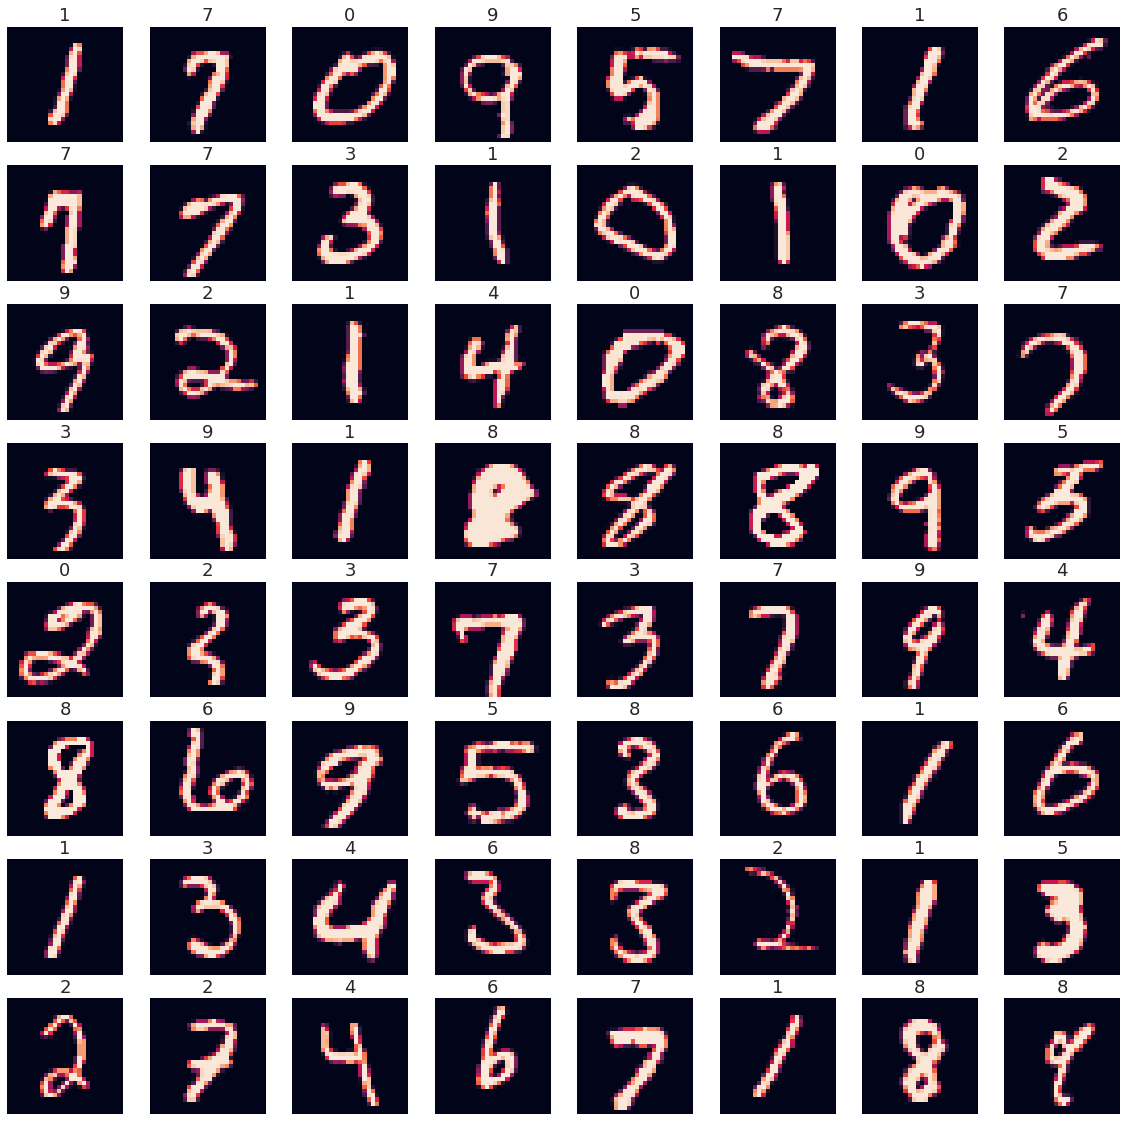

In [22]:
fig, axs = plt.subplots(8,8, figsize=(20,20))
axsf = [item for s in axs for item in s]

for n,ax in enumerate(axsf):
    ax.imshow(X[n].squeeze().numpy())
    ax.axis('off')
    ax.set_title(predicted[n].item())
    
plt.show()

In [23]:
ray.shutdown()


In [ ]:
# https://github.com/ray-project/ray/issues/4569

In [ ]:
# Exercises
# - change out the optimiser for adam
# - add network hyperparameters